In [80]:
from keras.layers import Input, Dense, Dropout, ELU, Activation
from keras.models import Sequential, Model
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from keras.initializers import RandomNormal

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [93]:
n_channels = 86

model = Sequential([
    Dense(40, input_dim=n_channels,
         kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * n_channels), seed=None)),
    Activation("relu"),
    Dense(19, kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * 19), seed=None)),
    Activation("relu"),
    Dense(40, kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * 19), seed=None)),
    Activation("relu"),
    Dense(n_channels, kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * n_channels), seed=None))
])
model.compile(optimizer='rmsprop',
              loss='mse')
model2 = Sequential([
    Dense(40, input_dim=n_channels,
         kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * n_channels), seed=None)),
    Activation("relu"),
    Dense(19, kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * 19), seed=None)),
    Activation("relu"),
    Dense(40, kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * 19), seed=None)),
    Activation("relu"),
    Dense(n_channels, kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * n_channels), seed=None))
])
model2.compile(optimizer='adam',
              loss='mse')

In [9]:
A = np.load("0_11500000102_0.npy")

In [20]:
ss = StandardScaler()
A = ss.fit_transform(A)

/Users/krzysztof/work/virtualenvs/daftlearning/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [21]:
A_train = A[:, :100000].T
A_test = A[:, 100000:].T

In [95]:
for epochs in range(10):
    for step in range(0, A_train.shape[1], 128):
        model.fit(A_train[:, step:(step+128)], A_train[:, step:(step+128)], epochs=1, batch_size=128)
    print mean_squared_error(model.predict(A_train), A_train)
#model.fit(A_train, A_train, epochs=10, batch_size=128)

Epoch 1/1
100000/100000 [==============================] - 3s 28us/step - loss: 0.6986

In [40]:

B = model.predict(A_test[0, :].reshape((1, 86)))
B

array([[-0.58719385, -0.7515095 ,  0.7754185 ,  2.6996722 , -0.43745026,
        -1.2549326 , -1.1964518 , -0.84901524, -0.6112233 , -0.24785183,
        -3.9058218 , -0.16398525,  1.0473115 ,  3.3682108 ,  0.22396451,
         0.46036708,  0.3789185 ,  0.42924207,  0.33418822,  0.3250668 ,
         0.20651719,  0.27761027,  0.2704268 ,  0.3371284 ,  0.63197637,
         0.7531051 ,  1.3718008 ,  0.6273227 , -0.09806973,  0.42428496,
         0.8168355 ,  0.9416399 ,  1.6147928 ,  0.57737255, -0.25178266,
        -0.9518933 , -0.6192049 ,  0.12838346, -3.2891386 , -0.24044277,
         2.2000737 , -0.21111573, -0.18503496, -0.20762801, -0.20919141,
        -0.23832166, -0.2315507 , -0.2029855 , -0.17659248, -0.07190323,
        -0.21301839, -0.21415083, -0.22825477, -0.24328083, -0.23202486,
        -0.22763306, -0.2187126 , -0.13312176, -0.22663808, -0.21023393,
        -0.23275076, -0.238641  , -0.23721331, -0.2703658 , -0.19758375,
        -0.25354904, -0.23409437, -0.24308014, -0.2

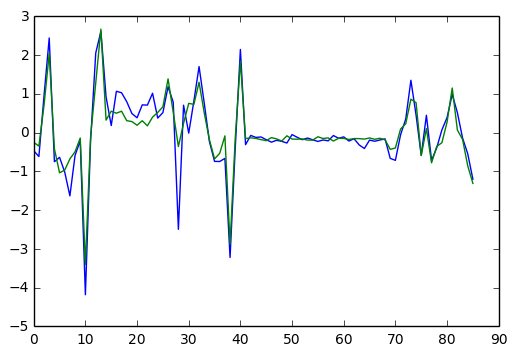

0.14817739035880287

In [86]:
plt.plot(A_test[0, :])
plt.plot(B.reshape((86,)))
plt.show()
mean_squared_error(A_test[0, :], B.reshape((86,)))

In [72]:
mean_squared_error(A_test, model.predict(A_test))

0.16587860175141528

In [44]:
A_test[:, 0].shape

(53600,)

In [67]:
def random_noise(X):
    bn = np.random.binomial(2, 0.07, X.shape)
    sh = X.copy()
    for i in xrange(sh.shape[1]):
        np.random.shuffle(sh[:, i])
        
    return bn * sh + (1 - bn) * X

In [68]:
mean_squared_error(A_train, random_noise(A_train))

0.29666433686071425

In [90]:
model2.fit(A_train, random_noise(A_train), epochs=30, batch_size=128)

Epoch 1/30
100000/100000 [==============================] - 2s 19us/step - loss: 0.4989

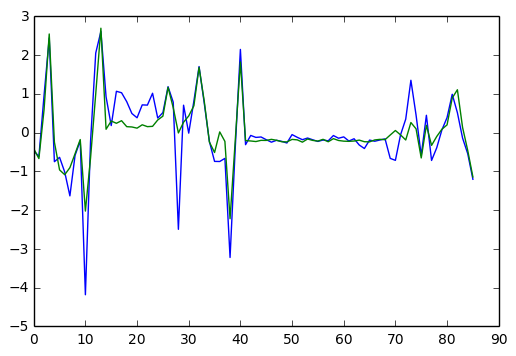

0.26686995554135073

In [91]:
B = model2.predict(A_test[0, :].reshape((1, 86)))
plt.plot(A_test[0, :])
plt.plot(B.reshape((86,)))
plt.show()
mean_squared_error(A_test[0, :], B.reshape((86,)))

In [92]:
mean_squared_error(A_test, model2.predict(A_test))

0.18688127946241886

In [131]:
class Autoencoder(object):
    def __init__(self, n_channels, dae_noise):
        """
        :param n_channels: number of channels in the recording
        :param dae_noise: parameter of DenoisingAutoEncoder - probability that the value in X will be replaced
        """
        inputs = Input((n_channels,))
        l1 = Dense(40, kernel_regularizer=regularizers.l2(1e-3), activation="relu",
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * n_channels)))(inputs)
        l2 = Dense(19, kernel_regularizer=regularizers.l2(1e-3), #activation="relu",
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * 19)))(l1)
        l3 = Dense(40, kernel_regularizer=regularizers.l2(1e-3), activation="relu",
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * 19)))(l2)
        training_layer = Dense(n_channels,
                               kernel_initializer=RandomNormal(mean=0.0, stddev=0.5 / np.sqrt(40 * n_channels)))(l3)
        self.unify_layer = Model(inputs=inputs, outputs=l2)
        self.training_layer = Model(inputs=inputs, outputs=training_layer)
        self.training_layer.compile(optimizer="adam", loss="mse")
        self.dae_noise = dae_noise

    def fit(self, X, y):
        self.training_layer.fit(X, y, epochs=5, batch_size=128)

    def unify(self, X):
        return self.unify_layer.predict(X)

    def predict(self, X):
        return self.training_layer.predict(X)

    def fit_transform(self, X):
        """
        This bad name for this function, because it's not actually fitting the Autencoder. I put this name
        for compability with PreprocessingFeatureExtraction
        :param X:
        :return: unification of X
        """
        st = StandardScaler()
        X = st.fit_transform(X).T

        return self.unify(X).T

In [124]:
A = np.load("0_11500000102_0.npy")
st = StandardScaler()
A = st.fit_transform(A)

In [130]:
DEA = Autoencoder(A.shape[0], 0.15)
DEA.fit(A.T, A.T)
B = DEA.unify(A.T)

Epoch 1/5
153600/153600 [==============================] - 4s 26us/step - loss: 0.6910

In [126]:
B[1, :]

array([ 0.35410863,  1.7536067 ,  0.33094177, -0.16375653, -2.1292555 ,
        0.00894015,  0.21944961, -3.4450204 , -1.3486974 , -1.7777117 ,
        0.10264438, -0.05169008,  0.03632483, -0.13774203, -0.12189898,
       -0.57373047,  0.6259871 ,  0.04273546, -2.4593112 ], dtype=float32)